## Packages

In [1]:
import pandas as pd
import pickle as pkl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

SUCCESS_THRESHOLD = 7.5

## Load Data

In [2]:
country_df = pd.read_pickle("../../data/post_processing//country_df.pkl")
comes_from_df = pd.read_pickle("../../data/post_processing/comes_from_df.pkl")
genre_df = pd.read_pickle("../../data/post_processing/genre_df.pkl")
is_of_type_df = pd.read_pickle("../../data/post_processing/is_of_type_df.pkl")
language_df = pd.read_pickle("../../data/post_processing/language_df.pkl")
spoken_languages_df = pd.read_pickle("../../data/post_processing/spoken_languages_df.pkl")
character_df = pd.read_pickle("../../data/post_processing/character_df.pkl")
actor_df = pd.read_pickle("../../data/post_processing/actor_df.pkl")
movie_df = pd.read_pickle("../../data/post_processing/movie_df.pkl")
belongs_to_df = pd.read_pickle("../../data/post_processing/belongs_to_df.pkl")
play_df = pd.read_pickle("../../data/post_processing/play_df.pkl")
appears_in_df = pd.read_pickle("../../data/post_processing/appears_in_df.pkl")
wikipedia_imdb_mapping_table = pd.read_pickle("../../data/generated/wikipedia_imdb_mapping_df.pkl")
is_directed_by_df = pd.read_pickle("../../data/post_processing/is_directed_by_df.pkl")
director_df = pd.read_pickle("../../data/post_processing/director_df.pkl")

## KM analysis for Directors

In [3]:
movie_director = pd.merge(pd.merge(director_df, is_directed_by_df, on='director_id'), movie_df, on='movie_id')[['director_id', 'birth_year', 'death_year', 'release_date', 'average_rating']]
movie_director.dropna(inplace=True)

movie_director['release_year'] = movie_director['release_date'].dt.year
movie_director.drop(['release_date'], axis=1, inplace=True)

movie_director['director_age'] = (movie_director['release_year'] - movie_director['birth_year'])
movie_director = movie_director[movie_director['director_age'] > 18]

# a movie is a success if rating higher than threshold and release before director's death
movie_director['success'] = np.where((movie_director.average_rating > SUCCESS_THRESHOLD) & (movie_director.release_year < movie_director.death_year),1,0)

movie_director.head()

,director_id,birth_year,death_year,average_rating,release_year,director_age,success
0,nm0000005,1918,2007,7.7,1955,37,1
1,nm0000005,1918,2007,7.2,1950,32,0
2,nm0000005,1918,2007,7.1,1960,42,0
3,nm0000005,1918,2007,7.6,1982,64,1
4,nm0000005,1918,2007,6.4,1948,30,0


In [4]:
directors = {}
for director, group in movie_director.groupby(['director_id', 'success']):        
    if director[1] == 1:
        directors[director[0]] = [1, group["director_age"].min()]
    else:
        if director[0] in directors:
            continue
        else:
            directors[director[0]] = [0, group["director_age"].max()]
director_km = pd.DataFrame(directors).transpose()
director_km.rename(columns={director_km.columns[0]: 'success', director_km.columns[1]: 'success_age'}, inplace=True)
director_km.head()

,success,success_age
nm0000005,1,37
nm0000008,0,37
nm0000009,0,42
nm0000018,0,59
nm0000019,1,33


In [5]:
director_sf = sm.SurvfuncRight(director_km["success_age"], director_km["success"])

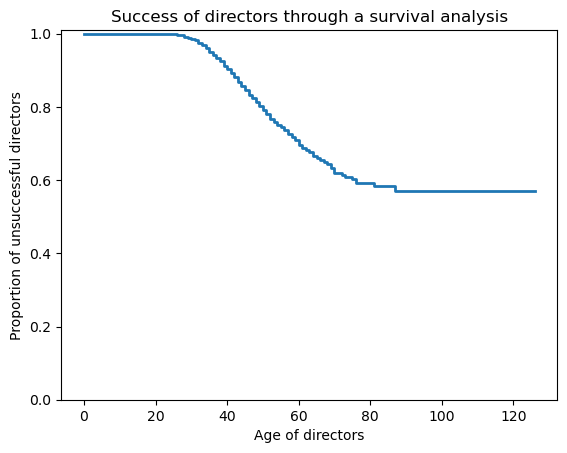

In [7]:
fig = director_sf.plot()
ax = fig.get_axes()[0]
pt = ax.get_lines()[1]
pt.set_visible(False)
plt.title("Success of directors through a survival analysis")
plt.xlabel("Age of directors")
plt.ylabel("Proportion of unsuccessful directors")
plt.show()